# Torch Implementation of WPE

## lib import

### imports

In [1]:
## NN
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# signals
import scipy.signal as signal
import numpy as np
from scipy.io import wavfile
# others
from tqdm import tqdm


In [2]:
a = torch.zeros(10)
print(a)
c = a.to(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


### function define

In [3]:
def lowpass_firwin(ntaps, fc, fs, window='hamming'):
    nyq = 0.5 * fs
    lpf_firwin = signal.firwin(ntaps, fc, nyq=nyq, pass_zero="lowpass", window=window)
    return lpf_firwin

def highpass_firwin(ntaps, fc, fs, window='hamming'):
    nyq = 0.5 * fs
    hpf_firwin = signal.firwin(ntaps, fc, nyq=nyq, pass_zero="highpass",window=window)
    return hpf_firwin

def bandpass_firwin(ntaps, fl, fh,  fs, window='hamming'):
    nyq = 0.5 * fs
    bpf_firwin = signal.firwin(ntaps, [fl, fh], nyq=nyq, pass_zero=False, window=window)
    return bpf_firwin

def bandreject_firwin(ntaps, fl, fh,  fs, window='hamming'):
    nyq = 0.5 * fs
    brf_firwin = signal.firwin(ntaps, [fl, fh], nyq=nyq, window=window)
    return brf_firwin



def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display( HTML( 
    '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
    '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
    ))

### Tool Box

In [4]:
def stft(input_sound, dft_size=256, hop_size=64, zero_pad=0, window=np.hanning(256)):
    # YOUR CODE HERE
    # 1. create windowed sound matrix
    num_hop = (len(input_sound)-dft_size)//hop_size+1
    sound_segments = np.zeros(((dft_size+zero_pad)//2+1, num_hop), dtype = 'complex_')
    i = 0
    col_idx = 0
    while(col_idx <= len(input_sound)-dft_size):
        windowed_segment = input_sound[col_idx:col_idx+dft_size]* window
        sound_segments[:,i] = np.fft.rfft(windowed_segment, n = dft_size+zero_pad)
        i += 1
        col_idx += hop_size
       
    # Return a complex-valued spectrogram (frequencies x time)
    return sound_segments

def istft( stft_output,  dft_size=256, hop_size=64, zero_pad=0, window=np.hanning(256)):
    # YOUR CODE HERE
    num_hop = len(stft_output[0])
    sound_length = (num_hop - 1) * hop_size + dft_size+zero_pad
    reconstruct_sound = np.zeros(sound_length)
    time_stamp = 0
    for col in range(0, len(stft_output[0])):
        ifft_slice = np.fft.irfft(stft_output[:,col],n=dft_size+zero_pad)
        reconstruct_sound[time_stamp:time_stamp+dft_size] += window*ifft_slice[0:dft_size]
        time_stamp += hop_size
   
    return reconstruct_sound

def plot_spectrum_f(stft, title):
    plt.figure(figsize=(15, 3))
    plt.pcolormesh(1000 * np.abs(stft) ** .5)
    plt.title(title)
    plt.colorbar()
    plt.show()

In [5]:
def plot_dictionary(result_dict, epoch_range, audio_range, title, result_type=1, reference_dict={}):
    num_audio = len(audio_range)
    num_epoch = len(epoch_range)
    if result_type == 1: # show loss
        plt.figure()
        fig, ax = plt.subplots(num_audio, num_epoch, figsize=(10*num_epoch, 2*num_audio))
        for audio_idx in range(num_audio):
            for epoch_idx in range(num_epoch):
                if num_epoch == 1:                
                    ax[audio_idx].plot(result_dict[(epoch_range[epoch_idx], audio_range[audio_idx])])
                    ax[audio_idx].set_title(f'Audio {audio_range[audio_idx]}, Epoch {epoch_range[epoch_idx]}')
                else:               
                    ax[audio_idx, epoch_idx].plot(result_dict[(epoch_range[epoch_idx], audio_range[audio_idx])])
                    ax[audio_idx].set_title(f'Audio {audio_range[audio_idx]}, Epoch {epoch_range[epoch_idx]}')


    elif result_type == 2:  # show change of filter (time domain input)
        plt.figure()
        fig, ax = plt.subplots(num_audio, 2*num_epoch, figsize=(20*num_epoch, 4*num_audio))
        for audio_idx in range(num_audio):
            for epoch_idx in range(num_epoch):
                current_fir_lst = result_dict[(epoch_range[epoch_idx], audio_range[audio_idx])]
                for i in range(len(current_fir_lst)):
                    current_fir = current_fir_lst[i]   
                    w, curr_freq_resp = signal.freqz(current_fir, 1)    
                    ax[audio_idx, 2*epoch_idx].plot(current_fir, label=f'{i} time stamp')
                    ax[audio_idx, 2*epoch_idx].set_title(f'Time Domain: Audio {audio_range[audio_idx]}, Epoch {epoch_range[epoch_idx]}')
                    ax[audio_idx, 2*epoch_idx].legend(loc ="upper right")
                    ax[audio_idx, 2*epoch_idx+1].plot(w, np.abs(curr_freq_resp), label=f'{i} time stamp')
                    ax[audio_idx, 2*epoch_idx+1].set_title(f'Frequency Domain {audio_range[audio_idx]}, Epoch {epoch_range[epoch_idx]}')
                    ax[audio_idx, 2*epoch_idx+1].legend(loc ="upper right")
                    
    elif result_type == 3: # show predict output
        plt.figure()
        fig, ax = plt.subplots(num_audio, num_epoch, figsize=(10*num_epoch, 2*num_audio))
        for audio_idx in range(num_audio):
            for epoch_idx in range(num_epoch):
                curr_reference = reference_dict[audio_range[audio_idx]]
                curr_reference = curr_reference.detach().clone().cpu()
                print(curr_reference.shape)
                if num_epoch == 1:                
                    ax[audio_idx].plot(result_dict[(epoch_range[epoch_idx], audio_range[audio_idx])], alpha=0.3)
                    ax[audio_idx].plot(curr_reference, alpha=0.3)
                    ax[audio_idx].set_title(f'Audio {audio_range[audio_idx]}, Epoch {epoch_range[epoch_idx]}')
                    ax[audio_idx].legend(["predict", "reference"])
                else:               
                    ax[audio_idx, epoch_idx].plot(result_dict[(epoch_range[epoch_idx], audio_range[audio_idx])], alpha=0.3)
                    ax[audio_idx, epoch_idx].plot(curr_reference, alpha=0.3)
                    ax[audio_idx, epoch_idx].set_title(f'Audio {audio_range[audio_idx]}, Epoch {epoch_range[epoch_idx]}')
                    ax[audio_idx, epoch_idx].legend(["predict", "reference"])                


    elif result_type == 4:  # show change of filter (frequency domain input)
        plt.figure()
        fig, ax = plt.subplots(num_audio, 2*num_epoch, figsize=(20*num_epoch, 4*num_audio))
        for audio_idx in range(num_audio):
            for epoch_idx in range(num_epoch):
                current_fir_lst = result_dict[(epoch_range[epoch_idx], audio_range[audio_idx])]
                for i in range(len(current_fir_lst)):
                    current_freq_resp = current_fir_lst[i]  # in frequency domain 
                    current_fir = np.fft.irfft(current_freq_resp)  
                    ax[audio_idx, 2*epoch_idx].plot(current_fir, label=f'{i} time stamp')
                    ax[audio_idx, 2*epoch_idx].set_title(f'Time Domain: Audio {audio_range[audio_idx]}, Epoch {epoch_range[epoch_idx]}')
                    ax[audio_idx, 2*epoch_idx].legend(loc ="upper right")
                    ax[audio_idx, 2*epoch_idx+1].plot(np.abs(current_freq_resp), label=f'{i} time stamp')
                    ax[audio_idx, 2*epoch_idx+1].set_title(f'Frequency Domain {audio_range[audio_idx]}, Epoch {epoch_range[epoch_idx]}')
                    ax[audio_idx, 2*epoch_idx+1].legend(loc ="upper right")
                  
    elif result_type == 5: # show predict output (frequency domain input)
        plt.figure()
        fig, ax = plt.subplots(num_audio, num_epoch, figsize=(10*num_epoch, 2*num_audio))
        for audio_idx in range(num_audio):
            for epoch_idx in range(num_epoch):
                current_predict_stft = result_dict[(epoch_range[epoch_idx], audio_range[audio_idx])]
                curr_reference_stft = reference_dict[audio_range[audio_idx]]
                curr_predict_t = istft(current_predict_stft)
                curr_reference_t = istft(curr_reference_stft)
                if num_epoch == 1:                
                    ax[audio_idx].plot(curr_predict_t, alpha=0.3)
                    ax[audio_idx].plot(curr_reference_t, alpha=0.3)
                    ax[audio_idx].set_title(f'Audio {audio_range[audio_idx]}, Epoch {epoch_range[epoch_idx]}')
                    ax[audio_idx].legend(["predict", "reference"])
                else:               
                    ax[audio_idx, epoch_idx].plot(curr_predict_t, alpha=0.3)
                    ax[audio_idx, epoch_idx].plot(curr_reference_t, alpha=0.3)
                    ax[audio_idx, epoch_idx].set_title(f'Audio {audio_range[audio_idx]}, Epoch {epoch_range[epoch_idx]}')
                    ax[audio_idx, epoch_idx].legend(["predict", "reference"])                
        
        for audio_idx in range(num_audio):
                for epoch_idx in range(num_epoch):
                    current_predict_stft = result_dict[(epoch_range[epoch_idx], audio_range[audio_idx])]
                    curr_reference_stft = reference_dict[audio_range[audio_idx]]
                    plot_spectrum_f(current_predict_stft, f'predict stft Audio {audio_range[audio_idx]}, Epoch {epoch_range[epoch_idx]}')
                    plot_spectrum_f(curr_reference_stft, f'reference stft Audio {audio_range[audio_idx]}, Epoch {epoch_range[epoch_idx]}')
    plt.tight_layout()
    fig.suptitle(title, fontsize = 20, style='italic')
    plt.subplots_adjust(top=0.9)
    plt.show()
        

## Load Data and Data Loader

### Load Dataset (in cpu now)

In [6]:
# generate reverb audio based on ir
def reverb_ir(audio, ir):
    # sound(rir, fs_rir)
    left = np.convolve(ir[:,0], audio)/2
    right = np.convolve(ir[:,1], audio)/2
    output = left+right
    return output


def dataset_loader_reverb(address, index_range, rir, length=5, dft_size=256, hop_size=64, zero_pad=0, window=np.hanning(256)):
    clean_dict = {}
    reference_dict = {}
    print('preparing reference audio... ')
    for i in tqdm(range(len(index_range))):
        # read current audio
        curr_name = str(index_range[i])
        addr = address + curr_name + '.wav'
        fs, data = wavfile.read(address+curr_name+'.wav')
        data = data.astype('float64')[0:length*fs] / 32768
        
        # generate reverberant audio and store clean/dirty to dict
        data_reverb = reverb_ir(data, rir)
        data_reverb = data_reverb[0:length*fs]
        data_stft = stft(data, dft_size=dft_size, hop_size=hop_size, zero_pad=zero_pad, window=window)
        data_reverb_stft = stft(data_reverb, dft_size=dft_size, hop_size=hop_size, zero_pad=zero_pad, window=window)
        clean_dict[i] = data_stft
        reference_dict[i] = data_reverb_stft
    return clean_dict, reference_dict, fs

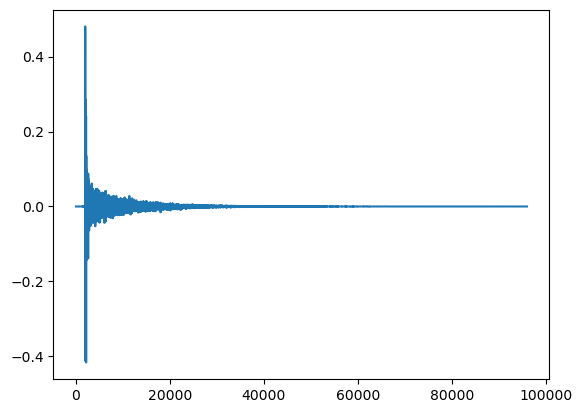

In [7]:
fs, rir = wavfile.read("dataset/IR/lyd3_000_ortf_48k.wav")
# rir[:,0] = rir[:,0]/np.sum(rir[:,0])
# rir[:,1] = rir[:,1]/np.sum(rir[:,1])
plt.plot(rir[:,0])

In [8]:
clean_dict, reference_dict, fs = dataset_loader_reverb('dataset/audio/speech/', np.linspace(1, 20, 20,dtype=int),rir)

preparing reference audio... 


100%|██████████| 20/20 [01:42<00:00,  5.14s/it]


In [9]:
N = len(reference_dict)
print('number of dataset are: ', N)

number of dataset are:  20


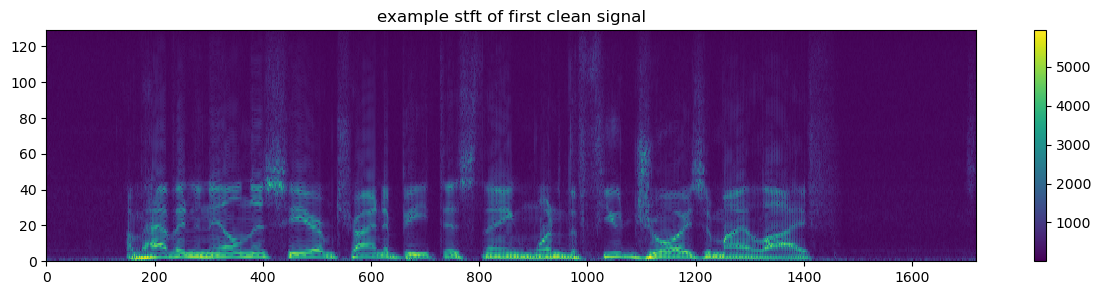

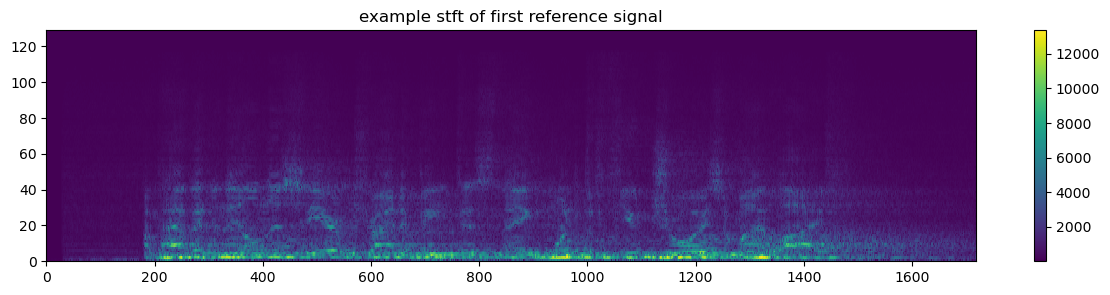

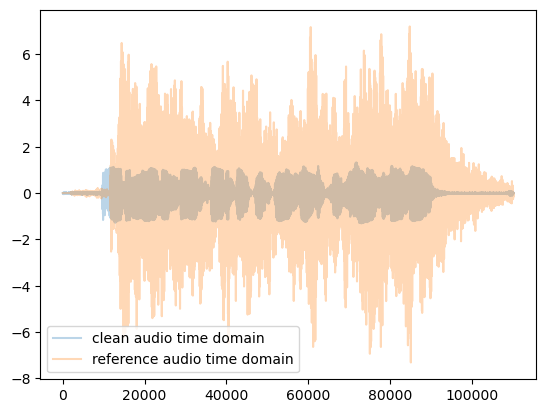

In [10]:
plot_spectrum_f(clean_dict[0], 'example stft of first clean signal')
plot_spectrum_f(reference_dict[0], 'example stft of first reference signal')
istft_clean = istft(clean_dict[0])
istft_reference = istft(reference_dict[0])
plt.plot(istft_clean, label='clean audio time domain', alpha=0.3)
plt.plot(istft_reference, label='reference audio time domain', alpha=0.3)
plt.legend()
plt.show()


# # filter_fir_resp = abs(np.fft.rfft(filter_fir))
# reference_conv = np.convolve(istft_input, filter_fir)
# plt.plot(istft_input, label='input audio time domain', alpha=0.3)
# plt.plot(istft_reference, label='reference from istft', alpha=0.3)
# plt.plot(reference_conv, label='reference from conv', alpha=0.3)
# plt.legend()
# plt.show()
# print(np.abs(reference_dict[0][:,0]))

In [11]:
sound(istft_reference, rate=22500)
sound(istft_clean, rate=22500)

### Define data loader

In [12]:
class torch_wpe_loader(Dataset):
    def __init__(self, reference_data, w, d):
        self.reference_data = reference_data
        self.w = w
        self.d = d

    def __len__(self):
        return self.reference_data.shape[1]
    
    def __getitem__(self, idx):
        return self.reference_data[:,idx-self.w-self.d:idx-self.d], self.reference_data[:,idx]

data_loader_dict = {}
for i in range(N):
    dset = torch_wpe_loader(reference_dict[i], 10, 3)
    data_loader_dict[i] = dset #DataLoader(dset, batch_size=1, shuffle=False)

In [13]:
prev, curr = data_loader_dict[0][4]
print(prev.shape, curr.shape)

(129, 0) (129,)


## Define Network and Optimizer

### Network

In [14]:
class WPE_optimizer(nn.Module):
    def __init__(self, w, f_range):
        super().__init__()
        w_size = w*f_range*2
        y_prev_size = w*f_range*2
        y_curr_size = f_range*2
        
        total_size = w_size + y_prev_size + y_curr_size
        
        self.fc1 = nn.Linear(total_size, 2*total_size, dtype=torch.float64)
        self.fc2 = nn.Linear(2*total_size, 2*total_size, dtype=torch.float64)
        self.fc3 = nn.Linear(2*total_size, w_size, dtype=torch.float64)
        
    def forward(self, w):
        w = torch.sgn(w) * torch.log1p(torch.abs(w))
        w = F.leaky_relu(self.fc1(w))
        w = F.leaky_relu(self.fc2(w))
        w = self.fc3(w)
        
        return w

In [15]:
def stack_real_imag(x):
    x_shape = x.shape
    x_flatten = torch.flatten(x)
    x_flatten_r = x_flatten.real
    x_flatten_i = x_flatten.imag
    x_flatten_ri = torch.cat((x_flatten_r, x_flatten_i))
    return x_flatten_ri, x_shape

def de_stack_real_imag(x, x_shape):
    x_r = x[0:int(len(x)/2)]
    x_i = x[int(len(x)/2):]
    x_r_matrix = torch.unflatten(x_r, 0, x_shape)
    x_i_matrix = torch.unflatten(x_i, 0, x_shape)
    x_complex = x_r_matrix + 1.j * x_i_matrix
    return x_complex

def calc_norm_factor(Y_curr, r1=1, r2=0, M=1):
    Y_H = torch.conj(Y_curr.T)
    mag = Y_H @ Y_curr
    # print(mag)
    factor = mag/(M*(r1+r2+1))
    # print(type(factor))
    return factor.real

In [19]:
loss_dict = {}
predict_dict = {}
filter_result_dict = {}
dft_size = 256
f_range = int(dft_size/2 + 1)
W = 10
d = 3
    

### Optimizer and loss

In [38]:
torch_wpe = WPE_optimizer(10, f_range).to(1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(torch_wpe.parameters(), lr=1e-2)

## Training (nn-sysid)

### Training Loop

In [39]:
# torch.cuda.empty_cache()

In [40]:
# !pip install GPUtil

# import torch
# from GPUtil import showUtilization as gpu_usage

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()                           


In [41]:
# begin training loop
for epoch in range(1):
    print("epoch: ", epoch)
    
    for j in range(1):
        print("audio: ", j)
        # pull out current data loader
        curr_data_loader = data_loader_dict[j]
        t_range = len(curr_data_loader)
        
        # initiate w
        init_w = torch.zeros(int(4*W*f_range+2*f_range), dtype=torch.float64).to(1)
        w = torch_wpe(init_w)
        for k in range(w.shape[0]):
            w[k] = 0.0          
        w_back_up = w.clone()   # backup a 'w' for later observation

        loss = 0
        predict_lst = np.zeros((int(f_range), int(t_range)), dtype=complex)
        loss_lst = []
        # filter_result_lst = []
        # filter_result_lst.append(de_stack_real_imag(w.detach().clone().cpu()))
        
        
        num_steps = len(curr_data_loader)-W-d
        for i in tqdm(range(W+d, num_steps)):
            # =======================================================================================
           
            # get input and reference data, give it to GPU and adjust dtype
            Y_prev, Y_curr = curr_data_loader[i]  
            Y_prev = torch.from_numpy(Y_prev).to(1) # F x 10
            Y_curr = torch.from_numpy(Y_curr).to(1) # F x 1
                        
            # stack real and imag
            Y_prev_stack, Y_prev_shape = stack_real_imag(Y_prev)
            Y_curr_stack, Y_curr_shape = stack_real_imag(Y_curr)
            
            # make everything in torch.float and to GPU (.cuda())
#             input_data_stack = torch.flatten(input_data_stack.type(torch.float64))
#             reference_data_stack = torch.flatten(reference_data_stack.type(torch.float64))     
            
            # cat all needed information (w, input_data, reference_data) to network's input
            network_in = torch.cat((w, Y_prev_stack, Y_curr_stack))

            # calculate the output (dw)           
            w = torch_wpe(network_in)
            
            w_destack = torch.conj(de_stack_real_imag(w, Y_prev_shape).T) # w_destack shape: (W, f_range)
            
            # print('w_destack: ', w_destack.shape, 'Y_prev: ', Y_prev.shape, 'Y_curr: ', Y_curr.shape)
            
            dot_product_overall_matrix = Y_prev @ w_destack
            Y_dot_result = torch.diagonal(dot_product_overall_matrix, 0)
            Y_pred = Y_curr - Y_dot_result
            norm_factor = calc_norm_factor(Y_curr)
            # print("nf: ", norm_factor)
            # print(torch.abs(Y_pred / norm_factor), torch.abs(Y_curr / norm_factor))
            # =======================================================================================           
            cur_loss = loss_function(torch.abs(Y_pred / norm_factor), torch.abs(Y_curr / norm_factor)).requires_grad_()
            loss = loss + cur_loss
            
            if i % 16 == 0 and i > 0:
                # calculate loss and do backward
                optimizer.zero_grad()
     
                loss.backward()
                optimizer.step()
                loss_lst.append(loss.item())
                w = w.detach().clone()

                loss = 0
            
            
            # =======================================================================================
            predict = Y_pred.clone()
            predict_lst[:,i] = predict.detach().cpu().numpy()
            
#             if i % (t_range // 5) == 0:
#                 filter_result_lst.append(w_destack.detach().clone().cpu())
                
        
        # filter_result_lst.append(de_stack_real_imag(w.detach().clone().cpu()))
            

        predict_dict[(epoch, j)] = predict_lst
        loss_dict[(epoch, j)] = loss_lst
        # filter_result_dict[(epoch, j)] =filter_result_lst


epoch:  0
audio:  0


100%|██████████| 1693/1693 [01:55<00:00, 14.63it/s]


### Examine Training Loss and Prediction

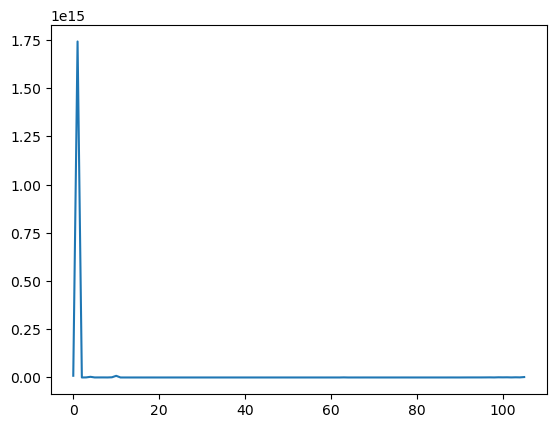

In [35]:
# plot_dictionary(loss_dict, range(0, 1), range(0, 1), "loss lists", result_type=1)
loss_00 = loss_dict[(0,0)]
plt.plot(loss_00)


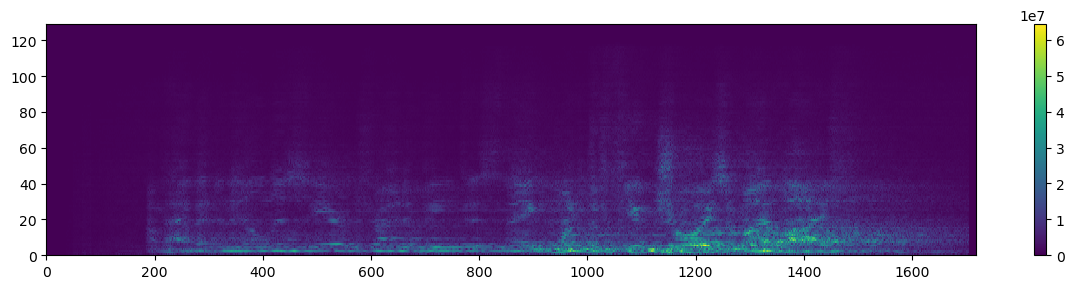

In [36]:
predict_00 = predict_dict[(0,0)]
plot_spectrum_f(predict_00,'')
istft_00 = istft(predict_00)
sound(istft_00, 22050, '')

(10, 129)


/home/yulun4/.local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


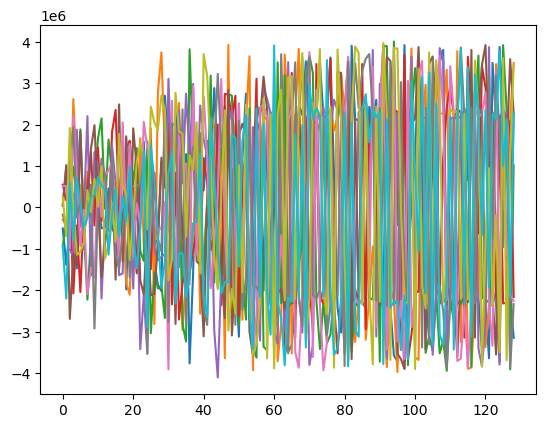

In [27]:
# plot_dictionary(filter_result_dict, range(0, 1), range(0, 10), "Coefficient Change of Each Epoch", result_type=4)

w_last_destack = w_destack.detach().cpu().numpy()
print(w_last_destack.shape)
for i in range(10):
    plt.plot(w_last_destack[i])

<Figure size 640x480 with 0 Axes>

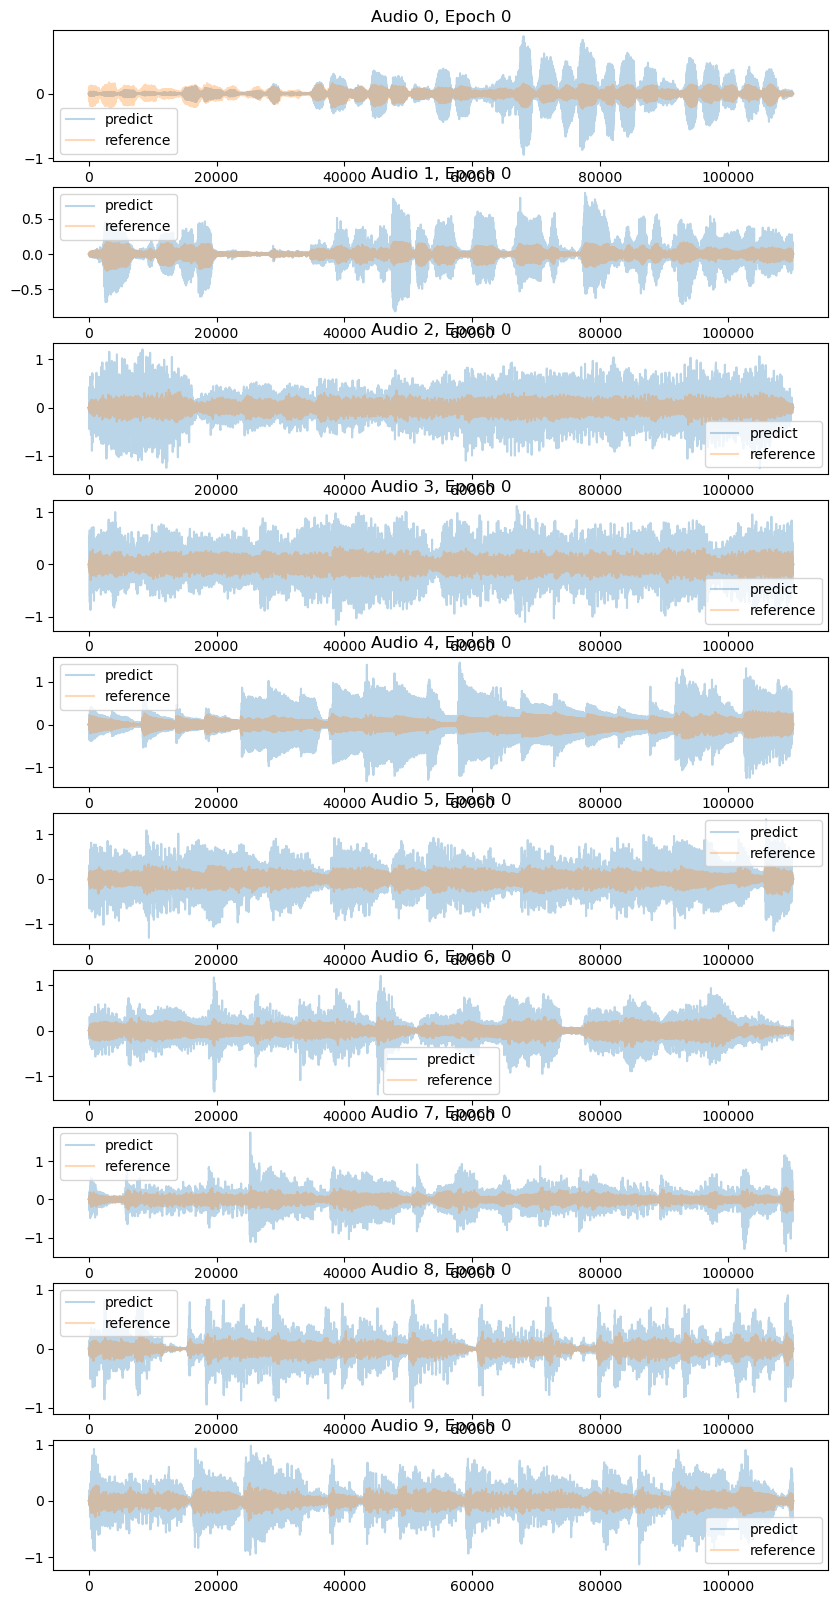

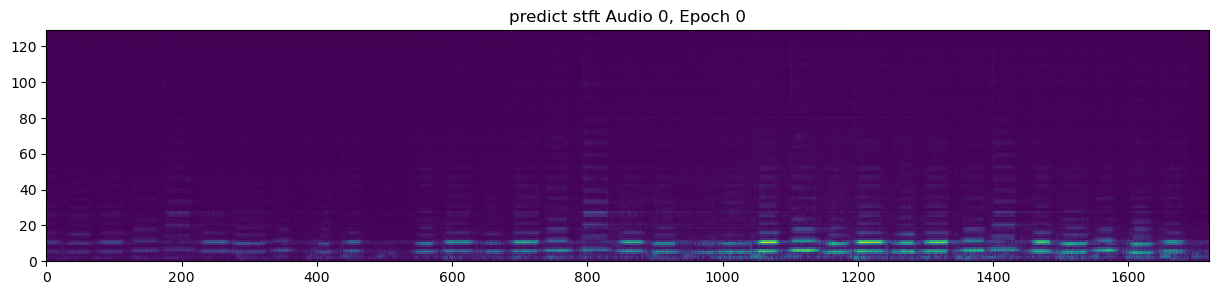

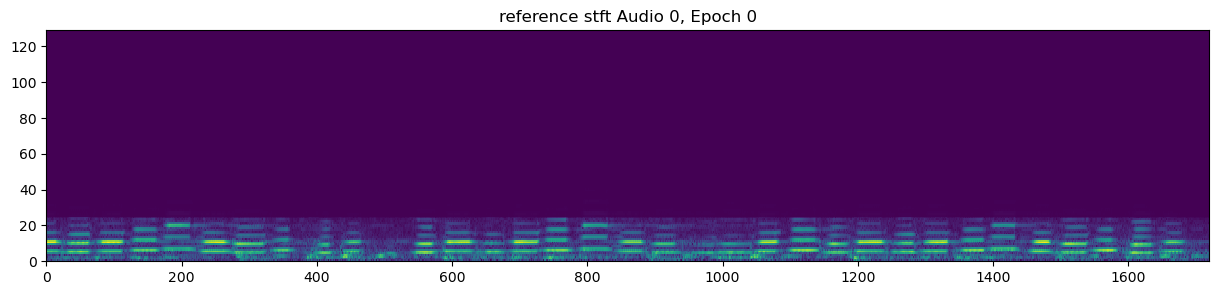

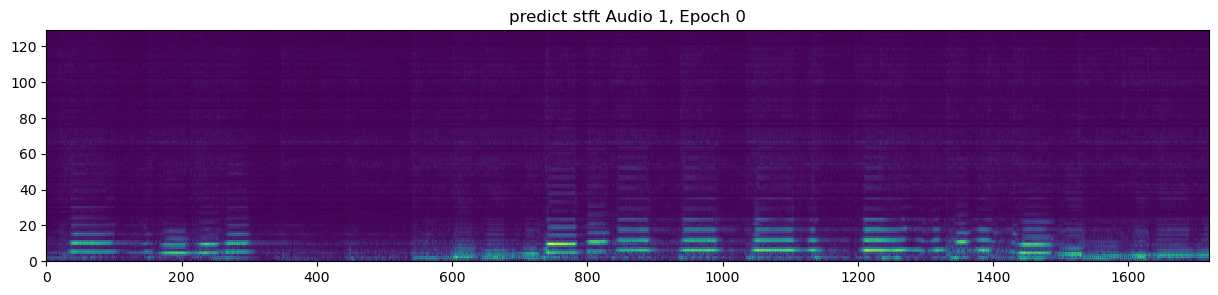

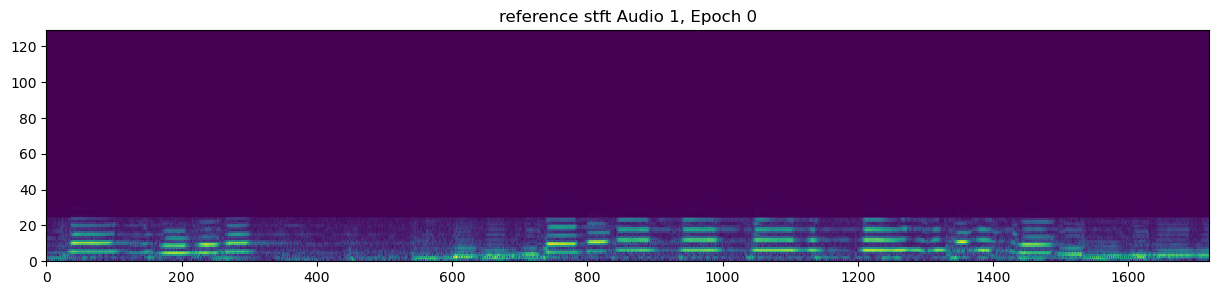

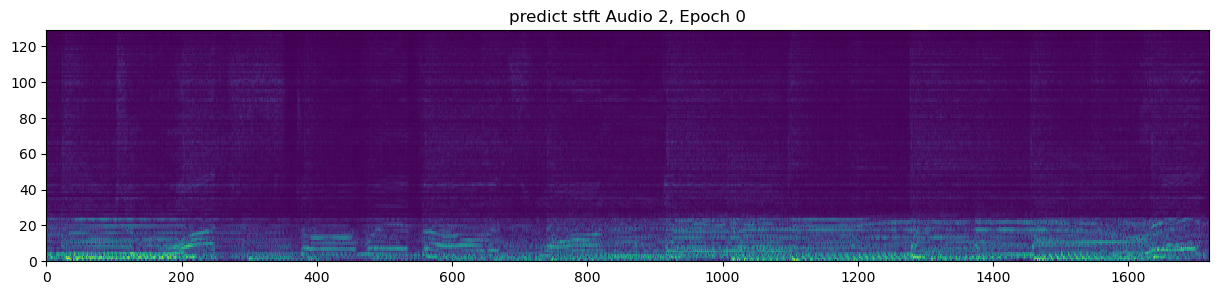

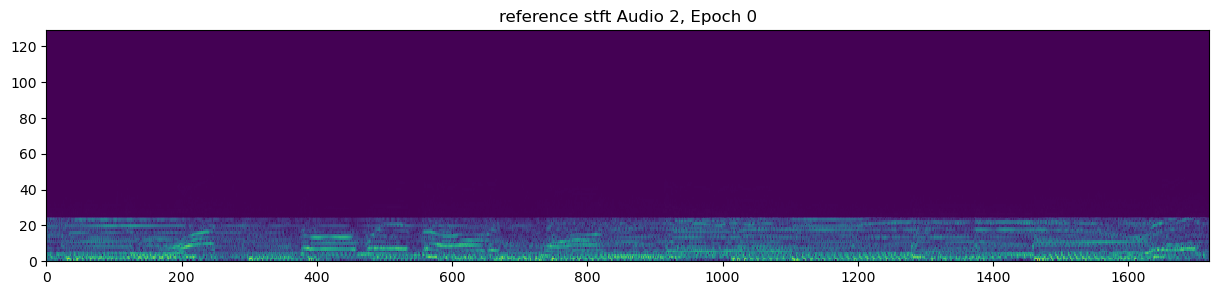

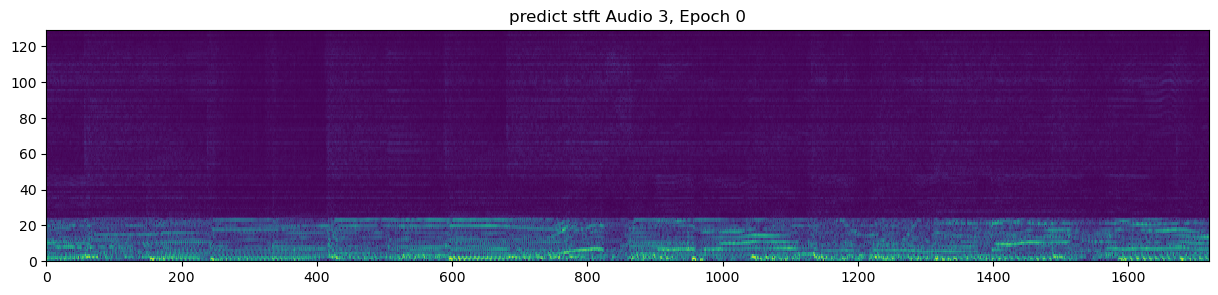

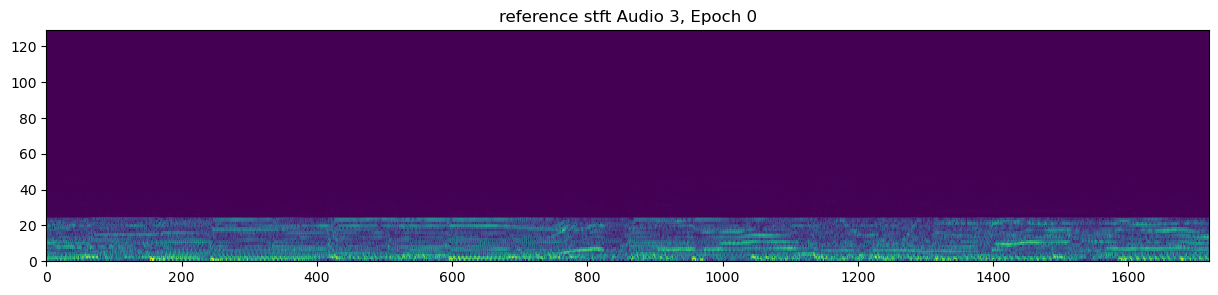

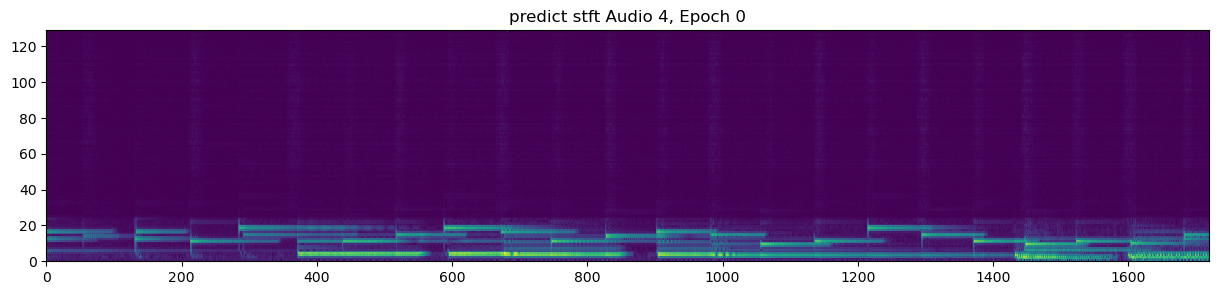

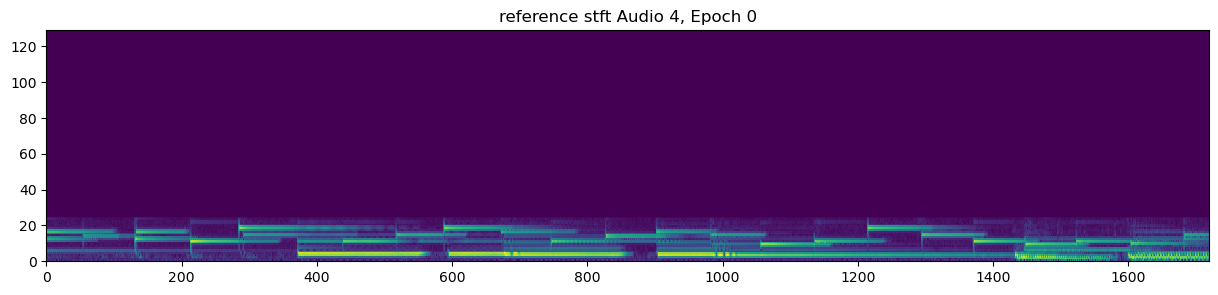

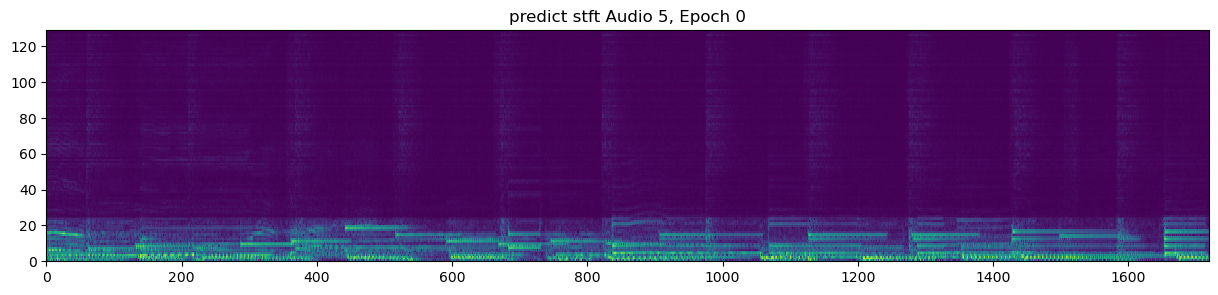

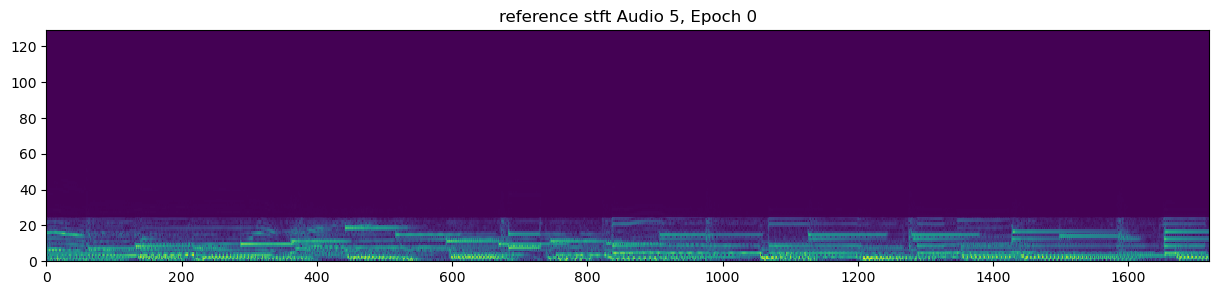

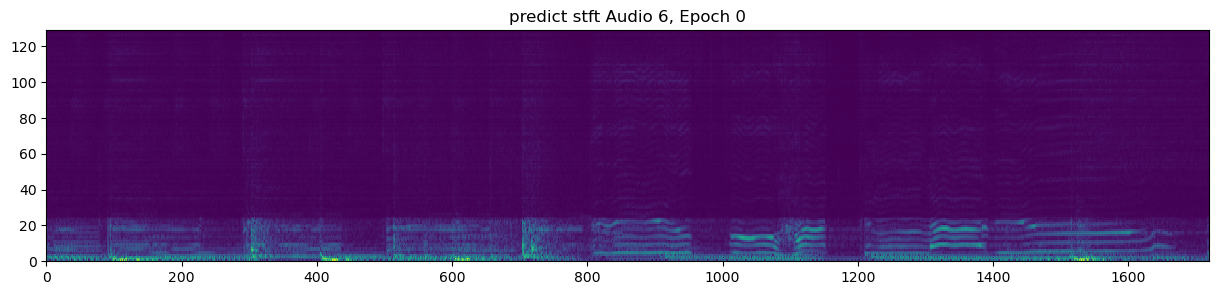

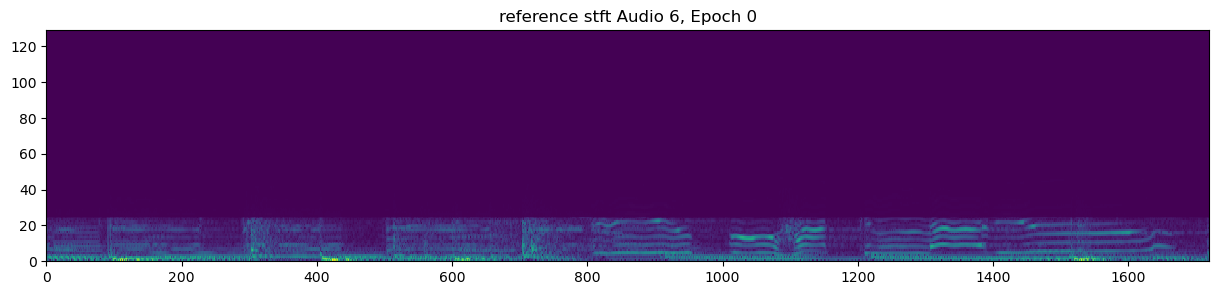

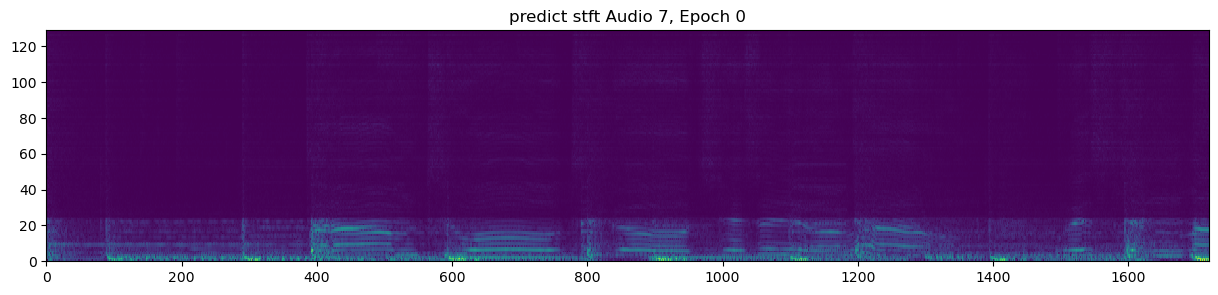

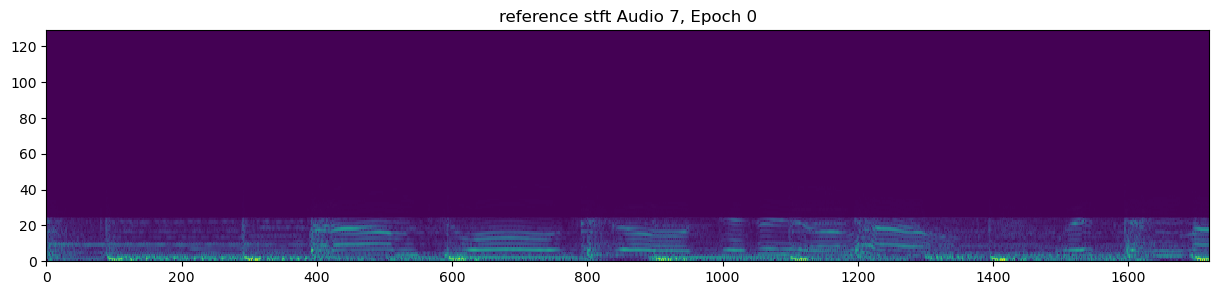

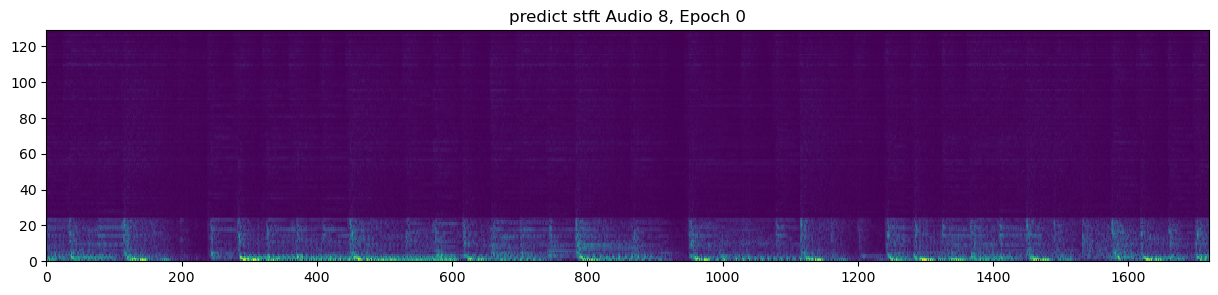

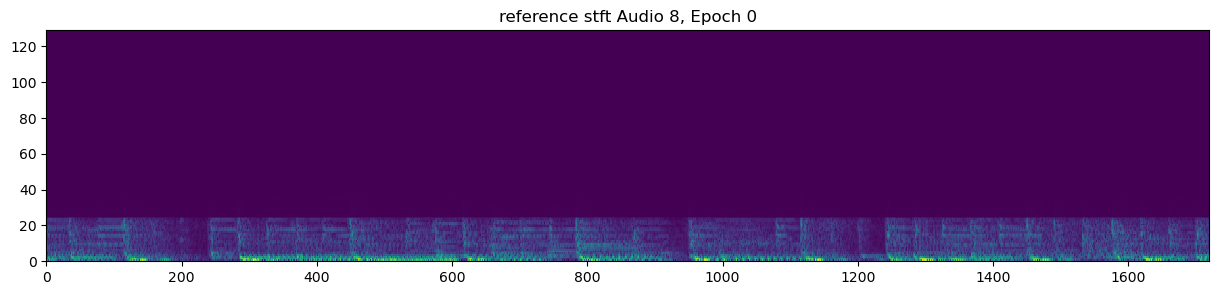

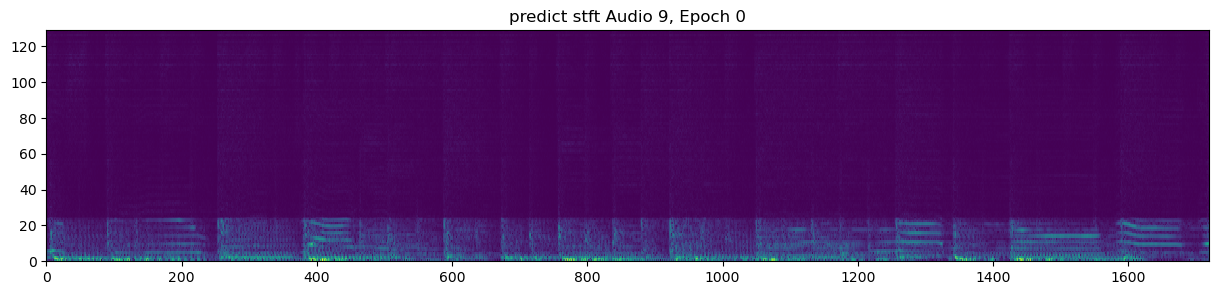

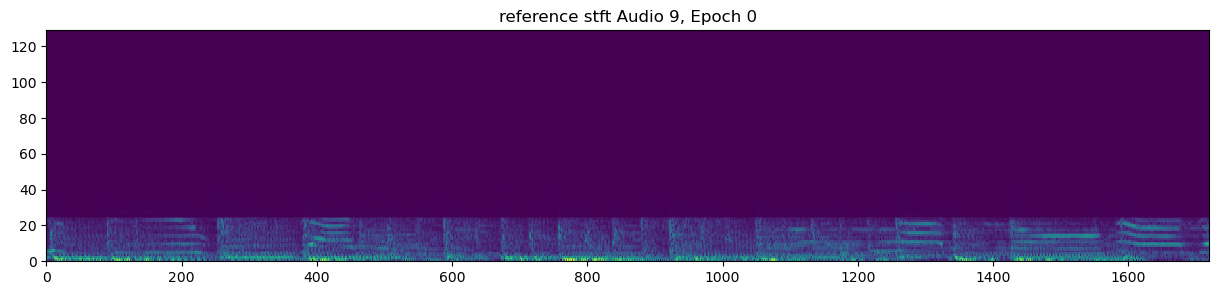

<Figure size 640x480 with 0 Axes>

In [305]:
plot_dictionary(predict_dict,range(0, 1), range(0, 10), "Compare of Predict Result and Reference Audio", result_type=5, reference_dict=reference_dict)

## Test Loop

In [306]:
loss_dict_test = {}
predict_dict_test = {}
filter_result_dict_test = {}
dft_size = 256
f_range = dft_size/2 + 1

for epoch in range(1):
    print("epoch: ", epoch)
    
    for j in range(40, 43):
        print("audio: ", j)
        # pull out current data loader
        curr_data_loader = data_loader_dict[j]
        t_range = len(curr_data_loader)
        
        # initiate w
        init_w = torch.zeros(int(6 * f_range), dtype=torch.float64).cuda()
        w = torch_sysid(init_w)
        for k in range(w.shape[0]):
            w[k] = 0.0          
        w_back_up = w.clone()   # backup a 'w' for later observation

        loss = 0
        predict_lst = np.zeros((int(f_range), int(t_range)), dtype=complex)
        loss_lst = []
        filter_result_lst = []
        filter_result_lst.append(de_stack_real_imag(w.detach().clone().cpu()))
        
        
        # num_steps = len(curr_data_loader)-W+1
        for i, data in tqdm(enumerate(curr_data_loader)):
            # =======================================================================================
            
            # get input and reference data, give it to GPU and adjust dtype
            input_data, reference_data = data  
            input_data = input_data.cuda()
            reference_data = reference_data.cuda()
            
            # stack real and imag
            input_data_stack = stack_real_imag(input_data)
            reference_data_stack = stack_real_imag(reference_data)
            
            
            
            # make everything in torch.float and to GPU (.cuda())
            input_data_stack = torch.flatten(input_data_stack.type(torch.float64))
            reference_data_stack = torch.flatten(reference_data_stack.type(torch.float64))     
            
            # cat all needed information (w, input_data, reference_data) to network's input
            network_in = torch.cat((w, input_data_stack, reference_data_stack))
            
            # calculate the output (dw)           
            w = torch_sysid(network_in)
            w_destack = de_stack_real_imag(w)
            
            # =======================================================================================           
            loss = loss_function(torch.abs(input_data*w_destack), torch.abs(reference_data)).requires_grad_()
            loss_lst.append(loss.item())   
            predict = (input_data * w_destack).clone()
            predict_lst[:,i] = predict.detach().cpu().numpy()            
            
            if i % (t_range // 5) == 0:
                filter_result_lst.append(w_destack.detach().clone().cpu())
                
            
        print('at the end of audio:', j, "current loss is: ", loss.item())   

        filter_result_lst.append(de_stack_real_imag(w.detach().clone().cpu()))
        predict_dict_test[(epoch, j)] = predict_lst
        loss_dict_test[(epoch, j)] = loss_lst
        filter_result_dict_test[(epoch, j)] =filter_result_lst


epoch:  0
audio:  40


1719it [00:02, 692.21it/s]


at the end of audio: 40 current loss is:  0.09135978814971986
audio:  41


1719it [00:02, 823.14it/s]


at the end of audio: 41 current loss is:  0.06561956385584863
audio:  42


1719it [00:02, 716.10it/s]

at the end of audio: 42 current loss is:  0.04134490146577439


### Examine Test Result

<Figure size 640x480 with 0 Axes>

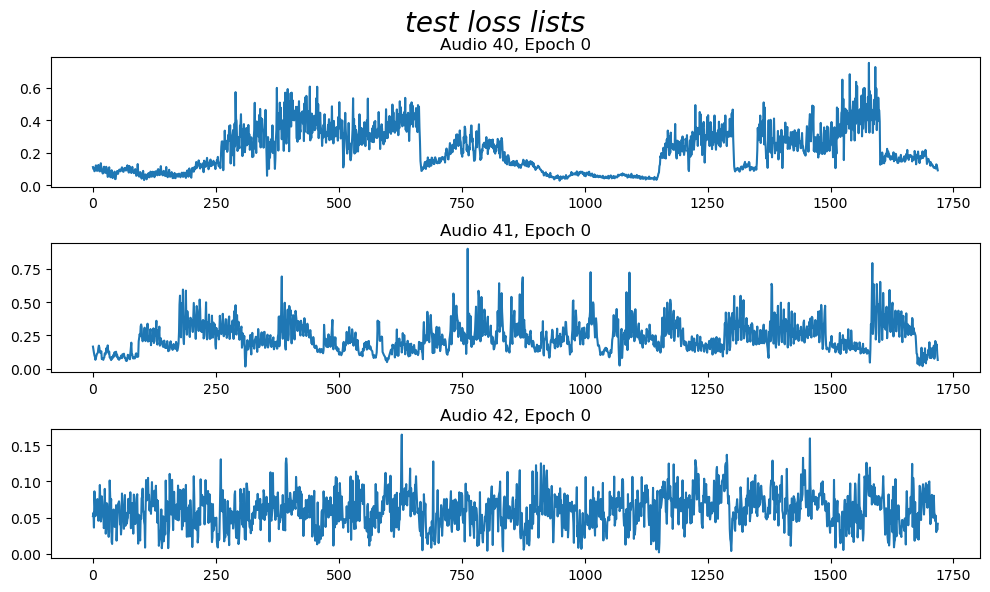

In [307]:
plot_dictionary(loss_dict_test, range(0, 1), range(40, 43), "test loss lists", result_type=1)

<Figure size 640x480 with 0 Axes>

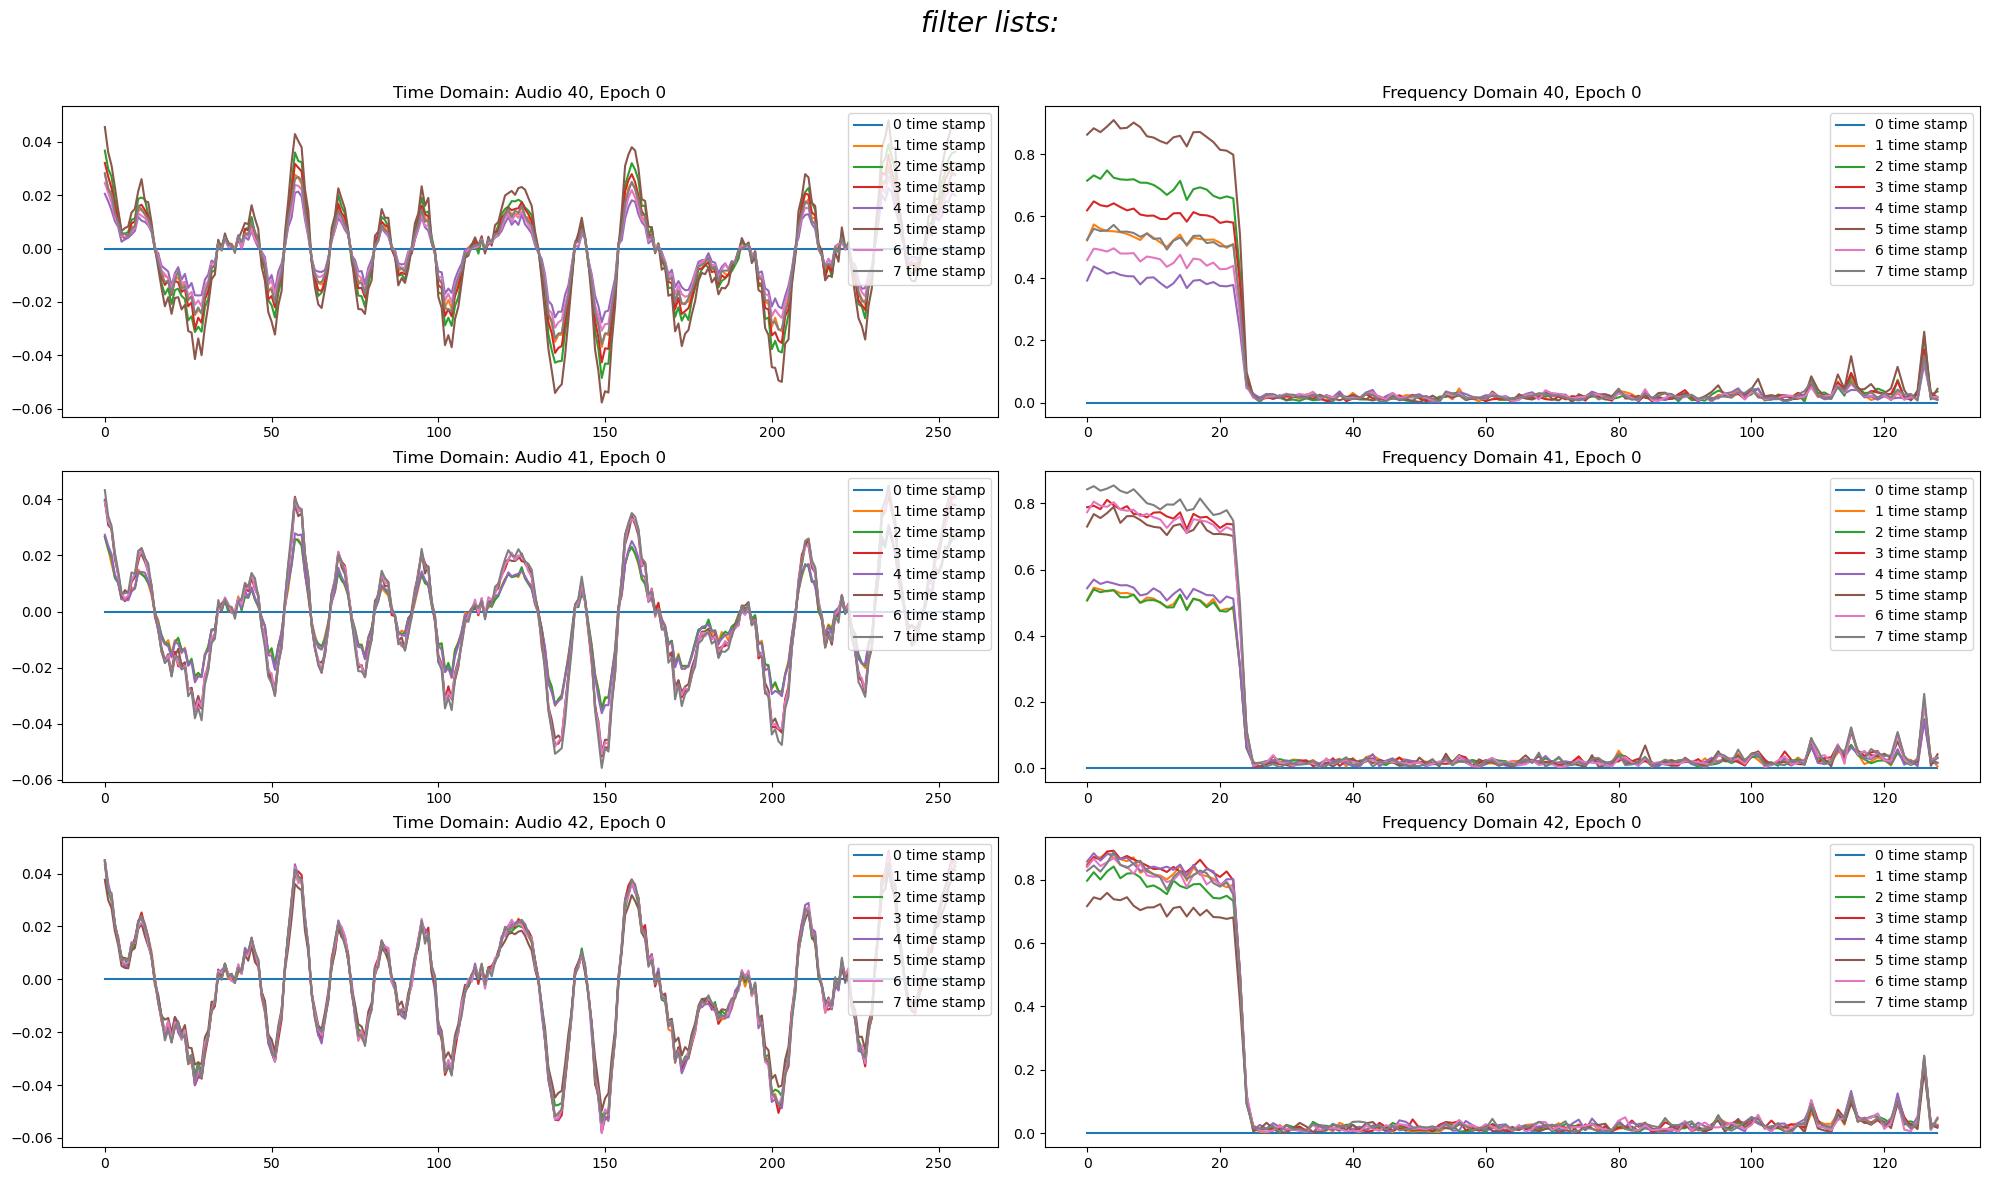

In [308]:
plot_dictionary(filter_result_dict_test, range(0, 1), range(40, 43), "filter lists: ", result_type=4)

<Figure size 640x480 with 0 Axes>

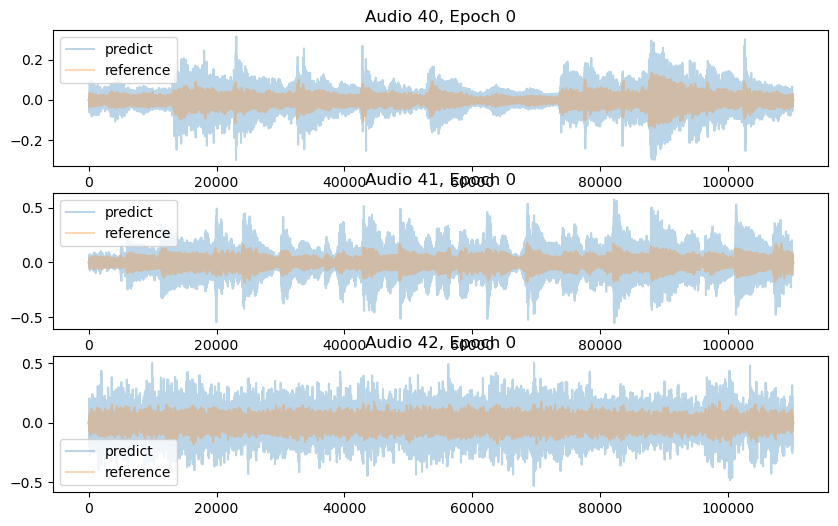

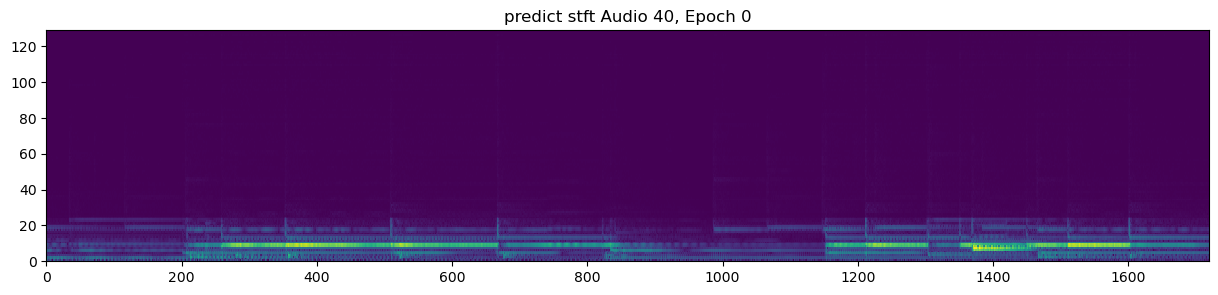

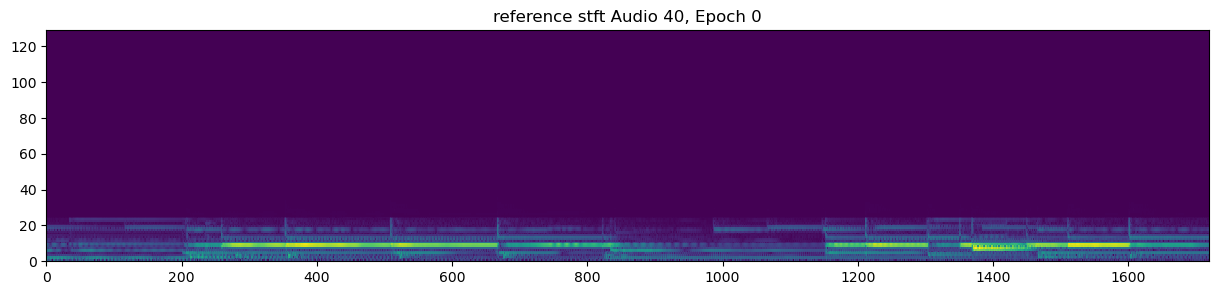

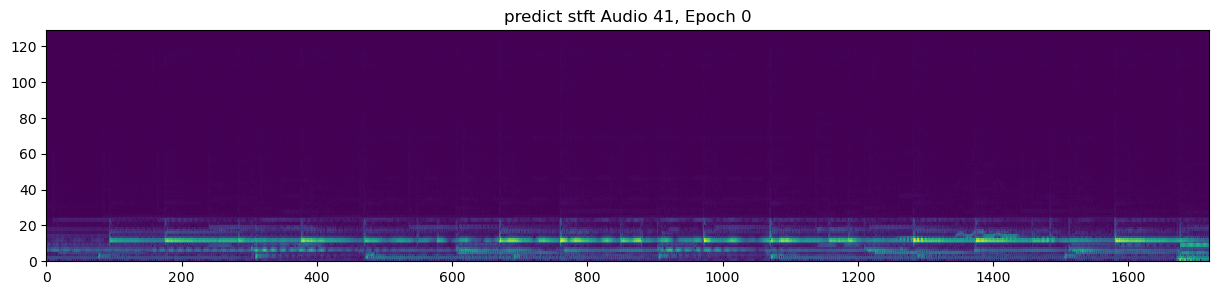

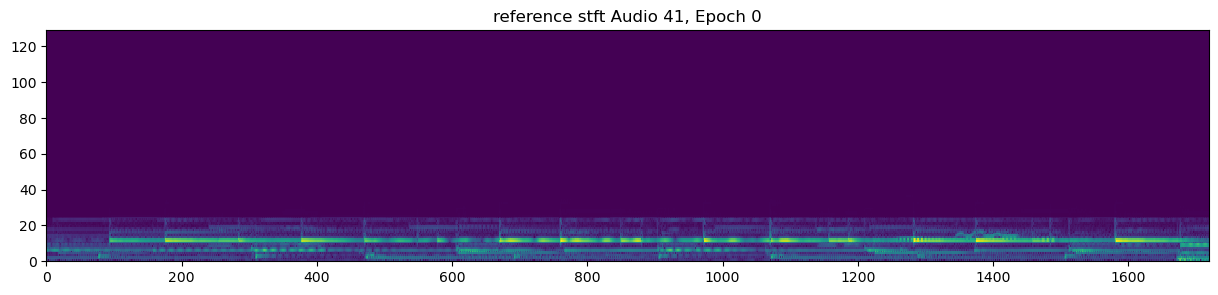

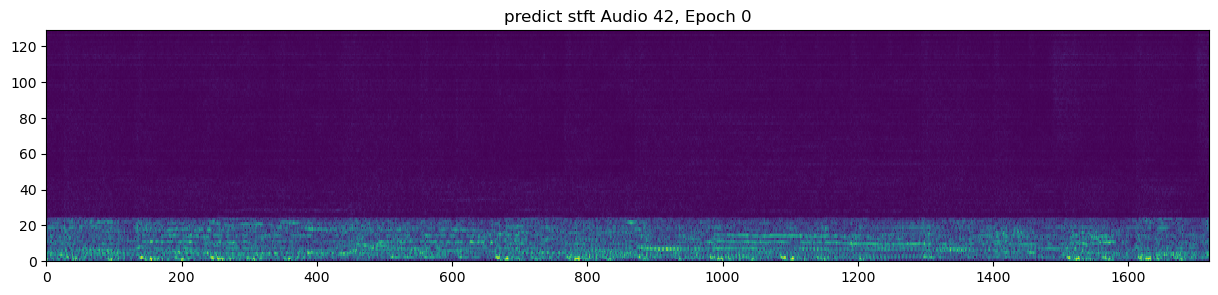

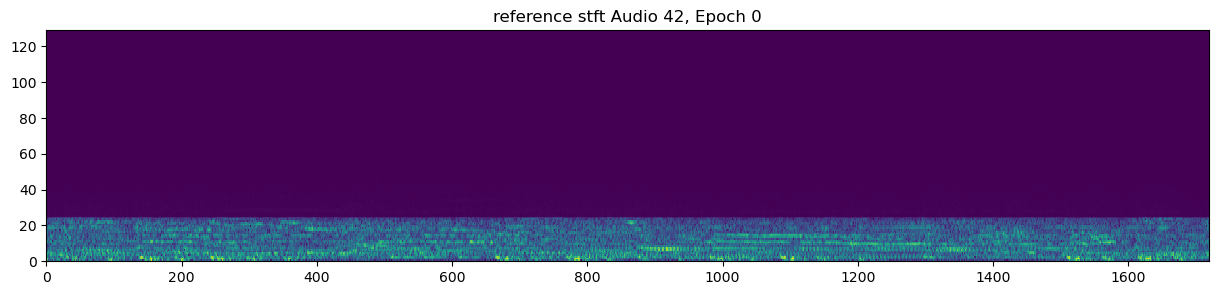

<Figure size 640x480 with 0 Axes>

In [309]:
plot_dictionary(predict_dict_test, range(0, 1), range(40, 43), "Testing Loop Filter Result", result_type=5, reference_dict=reference_dict)

## Unused Modules

### LMS module

In [ ]:
# lr = 3e-10
# loss_lst = []
# predict_lst = []

# for epoch in range(5):
#     print("epoch: ", epoch)
    
#     for j in range(N):
#         print("audio: ", j)
#         # initiate w (all zero)
#         w = torch.zeros(32, dtype=torch.float).cuda()
                    
#         # pull out current data loader
#         curr_data_loader = data_loader_dict[j]
        
#         for i, data in tqdm(enumerate(curr_data_loader)):
#             # =======================================================================================
            
#             # get input and reference data, give it to GPU and adjust dtype
#             input_data, reference_data = data  
            
#             # make everything in torch.float and to GPU (.cuda())
#             input_data = torch.flatten(input_data.type(torch.float)).cuda()
#             reference_data = torch.flatten(reference_data.type(torch.float)).cuda()    
            
#             # predict output:
#             predict_data = torch.dot(torch.conj(w), input_data)
            
#             # calculate error and gradient direction
#             error = reference_data - predict_data
#             gradient = lr * torch.conj(error) * input_data
            
#             loss_lst.append(error[0].cpu())
# #             print(loss_lst)
# #             print('input data: ', input_data)
# #             print('w: ', w)            
# #             print('reference data: ', reference_data)
# #             print('predict_data: ', predict_data)
# #             print('loss: ', error)
            
#             # update coefficient
#             w += gradient
            
#             # record loss
            